# Expressibility of the quantum circuit

In [33]:
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
import qutip
import qutip.qip.operations as gates
import qgrad
from gate_jax import *
from circuit_ansatz_jax import alternating_layer_ansatz

In [93]:
import pylab

## Generate a random Haar ket-state

In [5]:
def target(n_qubit, num_samples):
    target_array = []
    for i in range(num_samples):
        target_array.append(qutip.rand_ket_haar(N=2 ** n_qubit).data.A.T)
    
    return jnp.vstack(target_array)

In [6]:
target(3, 2)

DeviceArray([[-0.06328095-0.2514381j , -0.01647535+0.48268092j,
              -0.23734783-0.13391241j, -0.19113296-0.07303888j,
              -0.18162335+0.2870988j , -0.09213932+0.49386182j,
               0.22669998+0.20675522j,  0.3291233 -0.11456186j],
             [ 0.09293746+0.21558079j, -0.08548898+0.07307963j,
               0.4426485 -0.09789191j, -0.30063704+0.43161684j,
               0.01964221-0.22419743j, -0.00817894-0.08386742j,
               0.19681188+0.46123967j,  0.3383287 -0.16232102j]],            dtype=complex64)

## Define the circuit ansatz

In [84]:
def init_state(rng, n_qubit, n_layer):
    rng, sub_rng = jax.random.split(rng)
    params = jax.random.uniform(sub_rng, (n_qubit * n_layer,)) * 2 * jnp.pi
    # init_state = jnp.array([0] * (2 ** n_qubit - 1) + [1], dtype=jnp.complex64)

    return rng, params

In [85]:
rng = jax.random.PRNGKey(1)
rng, params = init_state(rng, 3, 2)

## Define the loss function

In [86]:
def state_norm(state, target_state):
    return jnp.real(jnp.sum((state - target_state) * (state - target_state).conj()))

In [87]:
def loss(params, n_qubit, s_block, n_layer, rot_axis, target_state):
    ansatz_state = alternating_layer_ansatz(params, n_qubit, s_block, n_layer, rot_axis)
    return state_norm(ansatz_state, target_state)

In [88]:
target_states = target(3, 2)
loss(params, 3, 3, 2, 'Y', target_states[0])

DeviceArray(2.1572602, dtype=float32)

In [89]:
jax.grad(loss)(params, 3, 3, 2, 'Y', target_states[0])

DeviceArray([-0.16564769,  0.10732129, -0.01638564, -0.00219846,
              0.03856766,  0.19179597], dtype=float32)

## Training loop

In [124]:
rng = jax.random.PRNGKey(1)
rng, params = init_state(rng, 3, 4)

opt_init, opt_update, get_params = optimizers.sgd(0.01)
opt_state = opt_init(params)

In [125]:
def step(step_num, opt_state, **kwargs):
    params = get_params(opt_state)
    loss_v, grad_v = jax.value_and_grad(loss)(params, **kwargs)
    return loss_v, opt_update(step_num, grad_v, opt_state)

In [127]:
loss_history = []
for train_step in range(5000):
    loss_v, opt_state = step(1, opt_state, 
                         n_qubit=3, s_block=3, n_layer=4, rot_axis='Y', target_state=target_states[0])
    loss_history.append(loss_v.item())

## Learning graph

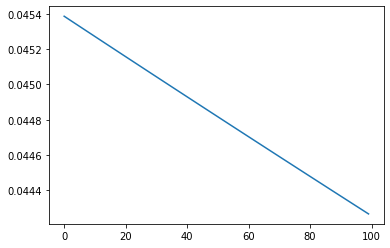

In [128]:
pylab.plot(loss_history[-100:])
pylab.show()

In [121]:
print(loss_history[-1] / 8)

0.004423650912940502


In [119]:
target_states[0]

DeviceArray([ 0.11095572-0.31906483j, -0.19275689-0.02592164j,
             -0.351689  +0.04523037j,  0.0706429 +0.2978408j ,
              0.0946818 +0.03552775j,  0.19820157+0.34060347j,
              0.06833559+0.44165215j, -0.45630237-0.23488107j],            dtype=complex64)

In [120]:
params = get_params(opt_state)
alternating_layer_ansatz(params, 3, 3, 3, 'Y') - target_states[0]

DeviceArray([ 0.00164125-0.06849992j, -0.01177835-0.01803414j,
             -0.06608334+0.02397836j, -0.04448254-0.02899536j,
             -0.03522258-0.10286979j,  0.00730236-0.0632945j ,
              0.02764422-0.06821924j,  0.01508155-0.03067657j],            dtype=complex64)

In [129]:
print(loss_history[-1] / 8)

0.005533394403755665
